# Floquet Dynamics of a Periodically Driven Spin Chain in the Full Hilbert Space

Analabha Roy

For more information about QuTiP see [http://qutip.org](http://qutip.org)

Hamiltonian of the driven Transverse Field Ising model of $N$ spins:
\begin{align*}
 H(t) &= H_0 + \left(h_0 + h\cos{\omega t}\right) H_1\\
H_0 &= -\frac12 \sum_{i<N} \sigma^x_i \sigma^x_{i+1} - \frac12 \sigma^x_N\sigma^x_0\\
H_1 &= -\frac12\sum_n^N \sigma^z_{n}
\end{align*}
The last term in $H_0$ ensures translational invariance by imposing periodic boundary conditions. By default, let us set $h_0=0$. The Floquet dynamics is contrasted with that of the driven Lipkin-Meshkov-Glick model, whose Hamiltonian involves long-range interactions. The Hamiltonian is
\begin{align*}
 H(t) &= H_0 + \left(h_0 + h\cos{\omega t}\right) H_1\\
H_0 &= \frac{2}{N-1}\sum_{i<j} \sigma^z_i \sigma^z_{j}\\
H_1 &= \sum_n^N \sigma^x_{n}
\end{align*}

Under periodic driving, we look at properties of the $2^N$ Floquet modes at time $t=T$. For each floquet mode at $t=T$, called $|\phi_n\rangle$, where $n\in[0, 2^N-1]$, let us define the *Inverse Participation Ratio* (PR) as the square of the magnon density, summed over all lattice sites
\begin{equation*}
\phi_{IPR}(n) \equiv \sum_m \left\vert\left\langle\phi_n\right\vert\sigma^+_m\sigma^-_m\left\vert\phi_n\right\rangle\right\vert^2
\end{equation*}
Here, $|m\rangle$ is the $m^{th}$ eigenstate of the transverse field, $\sigma_x$ in the Lipkin case, and $\sigma_z$ in the Ising case.

We set a large driving frequency ($\omega = 90$) and investigate two values of drive amplitude $h$. The first is a value of $h$ for which $J_0(\alpha h/\omega)=0$, where $\alpha=2$ for the Ising case and $\alpha=4$ for the Lipkin case. These are contrasted with PR plots far from this resonance. We simulate the exact Floquet dynamics and plot the PRs for both models. 

In [3]:
%%time

#Modded from qutip to allow parallelism
import numpy as np
import scipy.linalg as la
from numpy import angle, pi
from qutip import Qobj, propagator

def floquet_modes_mod(H, T, args=None, parallel=False, sort=False, U=None):
    """
    Calculate the initial Floquet modes Phi_alpha(0) for a driven system with
    period T.

    Returns a list of :class:`qutip.qobj` instances representing the Floquet
    modes and a list of corresponding quasienergies, sorted by increasing
    quasienergy in the interval [-pi/T, pi/T]. The optional parameter `sort`
    decides if the output is to be sorted in increasing quasienergies or not.

    Parameters
    ----------

    H : :class:`qutip.qobj`
        system Hamiltonian, time-dependent with period `T`

    args : dictionary
        dictionary with variables required to evaluate H

    T : float
        The period of the time-dependence of the hamiltonian. The default value
        'None' indicates that the 'tlist' spans a single period of the driving.

    U : :class:`qutip.qobj`
        The propagator for the time-dependent Hamiltonian with period `T`.
        If U is `None` (default), it will be calculated from the Hamiltonian
        `H` using :func:`qutip.propagator.propagator`.

    Returns
    -------

    output : list of kets, list of quasi energies

        Two lists: the Floquet modes as kets and the quasi energies.

    """
    if 'opts' in args:
        options = args['opts']
    else:
        options = Options()
        options.rhs_reuse = True
        rhs_clear() 
    
    if U is None:
        # get the unitary propagator
        U = propagator(H, T, [], args, parallel=parallel, progressbar=True, options=options)
    
    # find the eigenstates for the propagator
    evals, evecs = la.eig(U.full())

    eargs = angle(evals)

    # make sure that the phase is in the interval [-pi, pi], so that
    # the quasi energy is in the interval [-pi/T, pi/T] where T is the
    # period of the driving.  eargs += (eargs <= -2*pi) * (2*pi) +
    # (eargs > 0) * (-2*pi)
    eargs += (eargs <= -pi) * (2 * pi) + (eargs > pi) * (-2 * pi)
    e_quasi = -eargs / T

    # sort by the quasi energy
    if sort:
        order = np.argsort(-e_quasi)
    else:
        order = list(range(len(evals)))

    # prepare a list of kets for the floquet states
    new_dims = [U.dims[0], [1] * len(U.dims[0])]
    new_shape = [U.shape[0], 1]
    kets_order = [Qobj(np.matrix(evecs[:, o]).T,
                       dims=new_dims, shape=new_shape) for o in order]

    return kets_order, e_quasi[order]

CPU times: user 11 µs, sys: 4 µs, total: 15 µs
Wall time: 17.9 µs


In [4]:
%%time
import numpy as np
from qutip import tensor, sigmax, sigmay, sigmaz, qeye, mesolve, expect

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)

def get_sx(N):
    si = qeye(2)
    sx = sigmax()
    sx_list = []
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))
    SX = 0.0    
    for n in range(N):
        SX += sx_list[n] 
    return SX    

def get_density_operators(N):
    si = qeye(2)
    sy = sigmay()
    sz = sigmaz()
    s_plus = 0.5 * (sy + (1j)*sz)
    s_minus = 0.5 * (sy - (1j)*sz)
    
    density_op = s_plus * s_minus
    
    density_list = []
    
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = density_op
        operator = tensor(op_list)
        density_list.append(operator/operator.norm())
    return density_list


def get_hamiltonian_zzx(N, args,jmat = None, **kwargs):
    si = qeye(2)
    
    sx = sigmax()
    sz = sigmaz()

    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sz
        sz_list.append(tensor(op_list))
    # construct the hamiltonian
    H0 = 0.0

    # interaction terms
    for i in range(N-1):
        for j in range(i+1, N):
            H0 += jmat[i,j] * sz_list[i] * sz_list[j]
            
    H1 = get_sx(N)
    H = [H0,[H1,drive]]  
    return H

def get_observables_zzx(N, args,tlist=np.linspace(0,1,100),jmat = None, e_ops=None, **kwargs):
    if jmat is None:
        jmat = np.diag(np.ones(N),1)
    T = 2 * np.pi/args['omega']
    H = get_hamiltonian_zzx(N, args,jmat = jmat, **kwargs)
    opts = args['opts']
    SX = get_sx(N)
    _, psi0 = SX.groundstate()
    return mesolve(H, psi0,tlist ,c_ops = [], e_ops=e_ops ,args=args, options=opts)
    

def get_floquet_zzx(N, args,jmat = None, **kwargs):
    if jmat is None:
        jmat = np.diag(np.ones(N),1)
    T = 2 * np.pi/args['omega']
    return floquet_modes_mod(get_hamiltonian_zzx(N, args,jmat = jmat, **kwargs), T, args, **kwargs)

def get_ipr(N, args, **kwargs):
    f_states, _ = get_floquet_zzx(N,args,**kwargs)
    rhos = get_density_operators(N)
    ipr = np.array([np.sum([np.abs(expect(rho_i, state))**2 for rho_i in rhos]) for state in f_states])
    return ipr

CPU times: user 87 µs, sys: 27 µs, total: 114 µs
Wall time: 120 µs


In [7]:
M=5
ops = get_density_operators(M)
tot = 0.0

for op in ops:
    tot += op
    
display(tot)


Quantum object: dims = [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape = (32, 32), type = oper, isherm = True
Qobj data =
[[0.15625 0.03125 0.03125 ... 0.      0.      0.     ]
 [0.03125 0.15625 0.      ... 0.      0.      0.     ]
 [0.03125 0.      0.15625 ... 0.      0.      0.     ]
 ...
 [0.      0.      0.      ... 0.15625 0.      0.03125]
 [0.      0.      0.      ... 0.      0.15625 0.03125]
 [0.      0.      0.      ... 0.03125 0.03125 0.15625]]

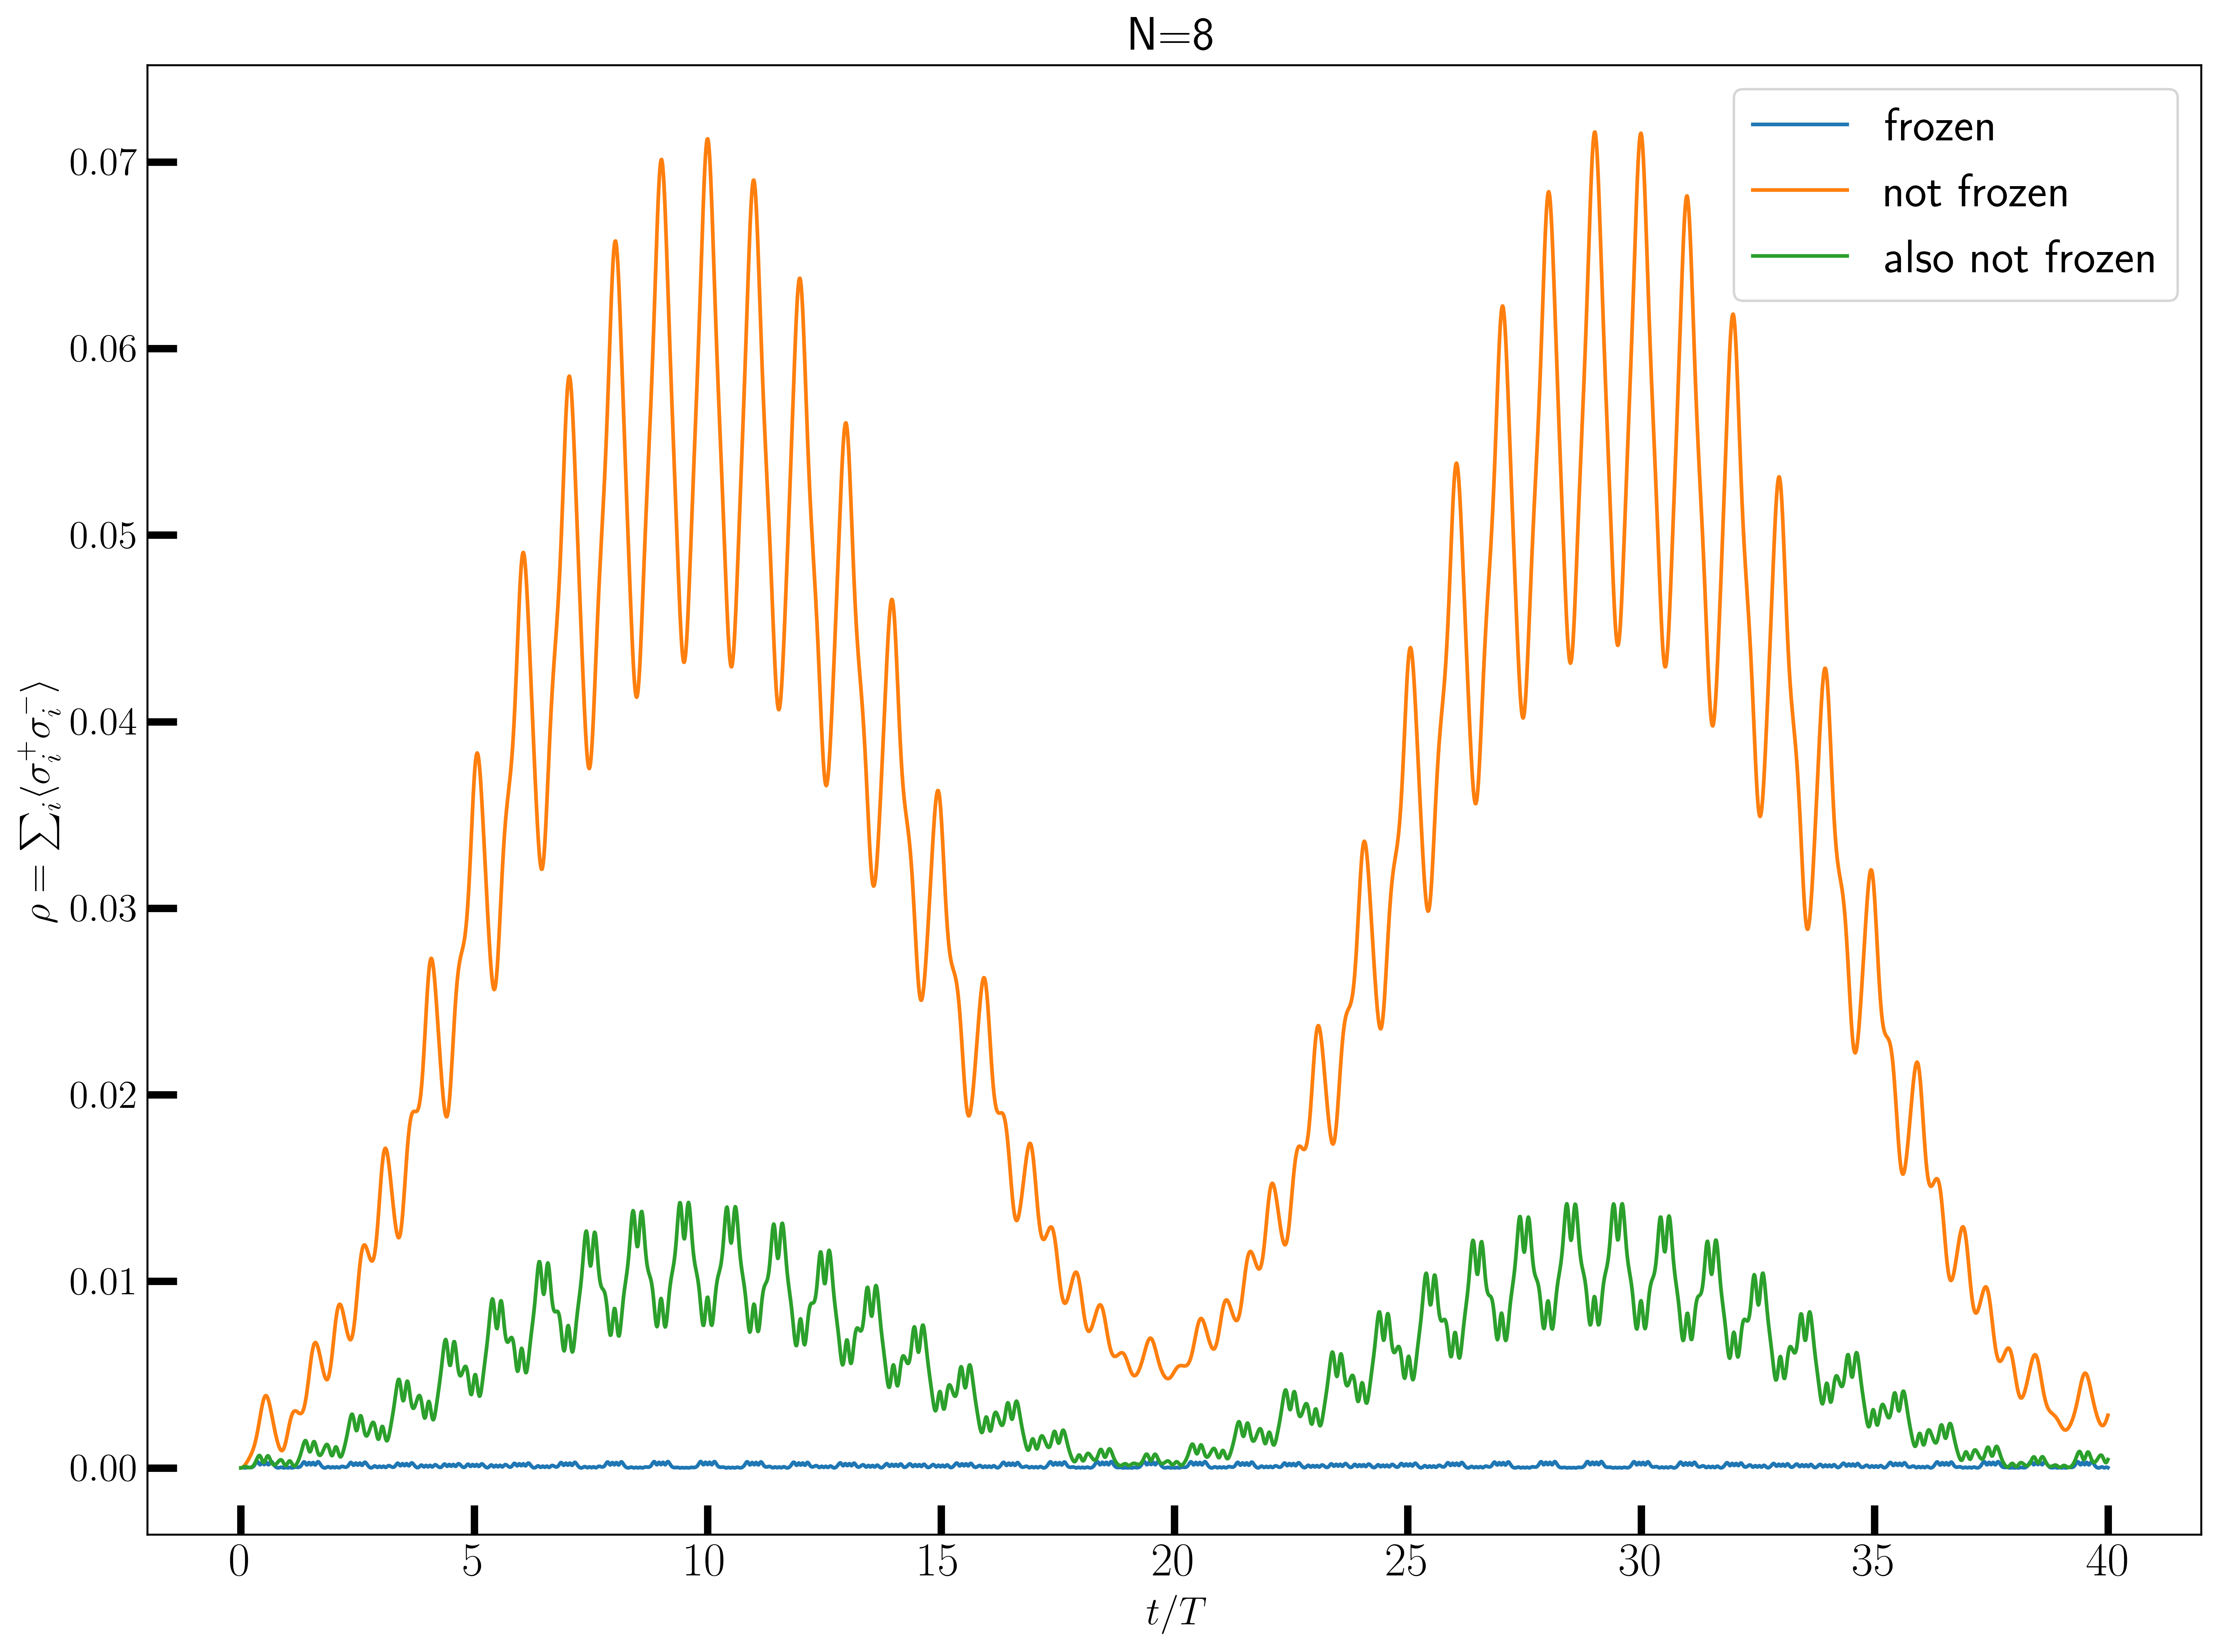

CPU times: user 15.4 s, sys: 2.59 s, total: 18 s
Wall time: 13.9 s


In [12]:
%%time
import numpy as np
from scipy.special import jn_zeros
from qutip import Options
import matplotlib.pyplot as plt
N=8
nprocs=4
jmat = np.full((N, N), 2/(N-1))
np.fill_diagonal(jmat,0)


ops = get_density_operators(N)
tot = 0.0

for op in ops:
    tot += op

omega = 90
h0 = np.pi/10
eta = jn_zeros(0,4)[-1]
h = eta * omega/4

opts = Options(nsteps=1e6, num_cpus=nprocs, openmp_threads=1, atol=1e-12, rtol=1e-14)

T = 2 * np.pi/omega
times = np.linspace(0,40*T,3200)

p = {"h0":h0, "omega":omega, "h":h, "opts":opts}
sol=get_observables_zzx(N,p,tlist=times,jmat=jmat, e_ops=tot)
sx_t = sol.expect[0]
plt.plot(times/T,sx_t, label="frozen")

p = {"h0":h0, "omega":omega, "h":omega*0.5, "opts":opts}
sol=get_observables_zzx(N,p,tlist=times,jmat=jmat, e_ops=tot)
sx_t = sol.expect[0]
plt.plot(times/T,sx_t, label="not frozen") 

p = {"h0":h0, "omega":omega, "h":h*0.5, "opts":opts}
sol=get_observables_zzx(N,p,tlist=times,jmat=jmat, e_ops=tot)
sx_t = sol.expect[0]
plt.plot(times/T,sx_t, label="also not frozen")

plt.title(f"N={N}")
plt.xlabel(r"$t/T$")
plt.ylabel(r"$\rho = \sum_i \langle \sigma^+_i\sigma^-_i \rangle$")
plt.legend()
plt.show()

In [8]:
import numpy as np
from scipy.special import jn_zeros
from qutip import Options
N=8
nprocs=4
jmat = np.full((N, N), 2/(N-1))
np.fill_diagonal(jmat,0)


omega = 0.2
h0 = np.pi/10
eta = jn_zeros(0,4)[-1]
h = eta * omega/4.0


opts = Options(nsteps=1e6, num_cpus=nprocs, openmp_threads=1, atol=1e-12, rtol=1e-14)

p_frz = {"h0":h0, "omega":omega, "h":h, "opts":opts}
iprs_frz = get_ipr(N,p_frz,jmat=jmat,parallel=True)
display(np.average(iprs_frz)*N)


p_nfrz = {"h0":h0, "omega":omega*0.5, "h":h, "opts":opts}
iprs_nfrz = get_ipr(N,p_nfrz,jmat=jmat,parallel=True)
display(np.average(iprs_nfrz)*N)

0.0010682577369360324

0.0010808314917299083

In [9]:
import numpy as np
from scipy.special import jn_zeros
from qutip import Options
N=8
nprocs=4
jmat = np.full((N, N), 2/(N-1))
np.fill_diagonal(jmat,0)


omega = 90.0
h0 = np.pi/10
eta = jn_zeros(0,4)[-1]
h = eta * omega/4.0


opts = Options(nsteps=1e6, num_cpus=nprocs, openmp_threads=1, atol=1e-12, rtol=1e-14)

p_frz = {"h0":h0, "omega":omega, "h":h, "opts":opts}
iprs_frz = get_ipr(N,p_frz,jmat=jmat,parallel=True)
display(np.average(iprs_frz)*N)


p_nfrz = {"h0":h0, "omega":omega*0.5, "h":h, "opts":opts}
iprs_nfrz = get_ipr(N,p_nfrz,jmat=jmat,parallel=True)
display(np.average(iprs_nfrz)*N)

0.0011296463923515588

0.0011101386638419073

In [10]:
import numpy as np
from scipy.special import jn_zeros
from qutip import Options
N=10
nprocs=4
jmat = np.full((N, N), 2/(N-1))
np.fill_diagonal(jmat,0)


omega = 0.2
h0 = np.pi/10
eta = jn_zeros(0,4)[-1]
h = eta * omega/4.0


opts = Options(nsteps=1e6, num_cpus=nprocs, openmp_threads=1, atol=1e-12, rtol=1e-14)

p_frz = {"h0":h0, "omega":omega, "h":h, "opts":opts}
iprs_frz = get_ipr(N,p_frz,jmat=jmat,parallel=True)
display(np.average(iprs_frz)*N)


p_nfrz = {"h0":h0, "omega":omega*0.5, "h":h, "opts":opts}
iprs_nfrz = get_ipr(N,p_nfrz,jmat=jmat,parallel=True)
display(np.average(iprs_nfrz)*N)

0.0001029124591750389

0.00010393980872247277

In [11]:
import numpy as np
from scipy.special import jn_zeros
from qutip import Options
N=10
nprocs=12
jmat = np.full((N, N), 2/(N-1))
np.fill_diagonal(jmat,0)


omega = 90
h0 = np.pi/10
eta = jn_zeros(0,4)[-1]
h = eta * omega/4.0


opts = Options(nsteps=1e6, num_cpus=nprocs, openmp_threads=1, atol=1e-12, rtol=1e-14)

p_frz = {"h0":h0, "omega":omega, "h":h, "opts":opts}
iprs_frz = get_ipr(N,p_frz,jmat=jmat,parallel=True)
display(np.average(iprs_frz)*N)


p_nfrz = {"h0":h0, "omega":omega*0.5, "h":h, "opts":opts}
iprs_nfrz = get_ipr(N,p_nfrz,jmat=jmat,parallel=True)
display(np.average(iprs_nfrz)*N)

0.00010612551735331555

0.0001058033522962941

### The Ising Case:

#### PR plots in the full Hilbert Space

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]


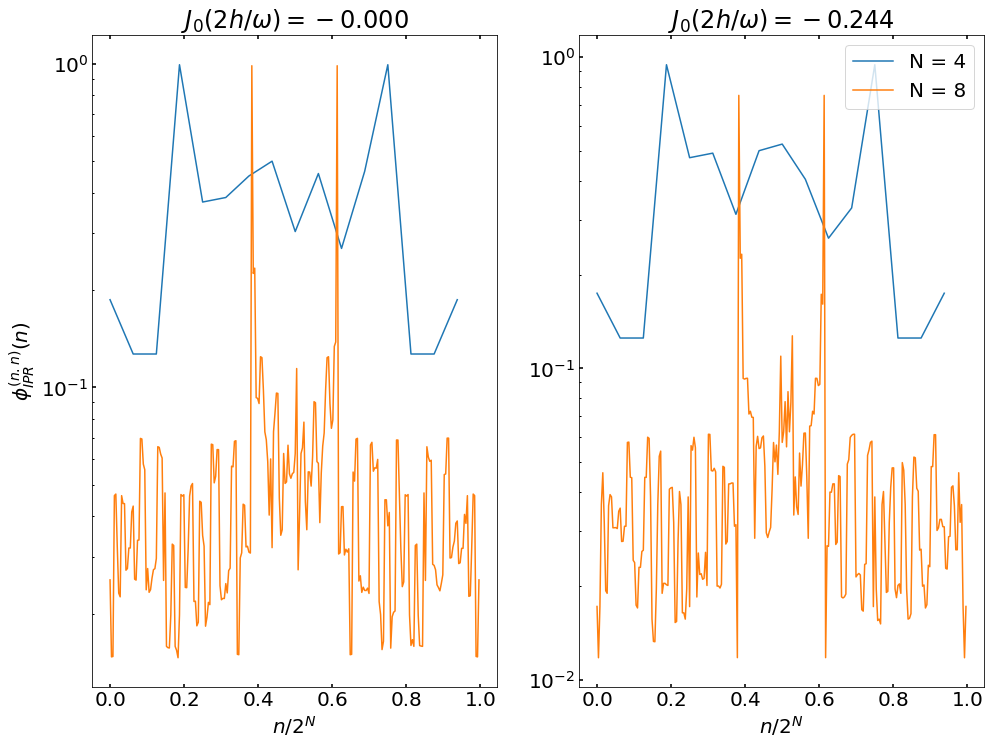

CPU times: user 1min 23s, sys: 1.22 s, total: 1min 25s
Wall time: 6.78 s


In [6]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros
from tqdm import tqdm

plt.rcParams.update({
    "figure.figsize": (16, 12),
    "text.usetex": False,
    "font.size": 20})

freezing_pts = jn_zeros(0, 5)
max_pts = jn_zeros(1,5)

#
# set up the calculation
#

Nvals = [4, 8]            # number of spins
omega = 20.0
w = omega
hfrz = omega * freezing_pts/2
hmax = 1.25 * omega * max_pts/2


fig, (ax0, ax1) = fig, axs = plt.subplots(1, 2)

h = hfrz[0]
params = {'h0':0.0, 'h':h, 'omega':omega}
ax0.set_title(fr"$J_0(2h/\omega)={j0(2*h/w):1.3f}$")
for N in tqdm(Nvals):
    idxvals = np.arange(2**N)/2**N
    ax0.plot(idxvals, get_iprvals(N, params, sort=True), label=f'N = {N}')

h = hmax[0]
params = {'h0':0.0, 'h':h, 'omega':omega}
ax1.set_title(fr"$J_0(2h/\omega)={j0(2*h/w):1.3f}$")
for N in tqdm(Nvals):
    idxvals = np.arange(2**N)/2**N
    ax1.plot(idxvals, get_iprvals(N, params, sort=True), label=f'N = {N}')
    
for ax in (ax0, ax1):
    ax.set_xlabel(r'$n/2^N$')
    ax.set_yscale("log")

ax0.set_ylabel(r'$\phi^{(n.n)}_{IPR}(n)$')
ax1.legend()
plt.show()

### The Lipkin Case

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:48<00:00, 56.17s/it]


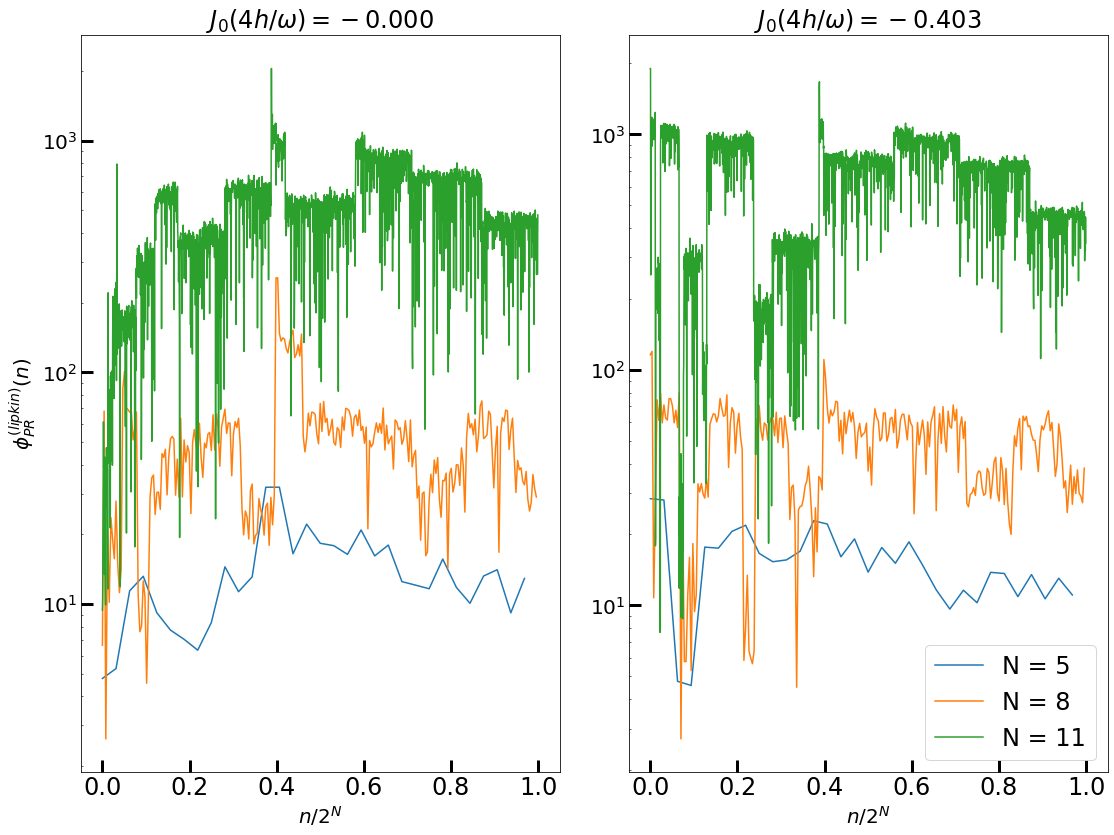

CPU times: user 23min 22s, sys: 50.3 s, total: 24min 12s
Wall time: 4min 47s


In [22]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros
from tqdm import tqdm

plt.rcParams.update({
    "figure.figsize": (16, 12),
    "text.usetex": False,
    "font.size": 20})

freezing_pts = jn_zeros(0, 5)
max_pts = jn_zeros(1,5)

#
# set up the calculation
#

Nvals = [5, 8, 11]            # number of spins
omega = 90.0
hfrz = omega * freezing_pts/4
hmax = omega * max_pts/4

def get_iprvals(N, params, **kwargs):
    f_states, f_energies = get_floquet_zzx(N, params, **kwargs)
    floquet_matrix = np.array(f_states)[:,:,0]
    return np.sum(np.abs(floquet_matrix)**4, axis=-1)

fig, (ax0, ax1) = fig, axs = plt.subplots(1, 2)

h = hfrz[0]
params = {'h0':0.0, 'h':h, 'omega':omega}
ax0.set_title(fr"$J_0(4h/\omega)={j0(4*h/w):1.3f}$")
for N in tqdm(Nvals):
    idxvals = np.arange(2**N)/2**N
    ax0.plot(idxvals, get_iprvals(N, params, jmat=2.0/(N-1)*np.ones((N,N)), sort=True), label=f'N = {N}')

h = hmax[0]
params = {'h0':0.0, 'h':h, 'omega':omega}
ax1.set_title(fr"$J_0(4h/\omega)={j0(4*h/w):1.3f}$")
for N in tqdm(Nvals):
    idxvals = np.arange(2**N)/2**N
    ax1.plot(idxvals, get_iprvals(N, params, jmat=2.0/(N-1)*np.ones((N,N)), sort=True), label=f'N = {N}')
    
for ax in (ax0, ax1):
    ax.set_xlabel(r'$n/2^N$')
    ax.set_yscale("log")

ax0.set_ylabel(r'$\phi^{(lipkin)}_{IPR}(n)$')
ax1.legend()
plt.show()

### Software version:

In [40]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.6.3
Numpy,1.20.3
SciPy,1.7.3
matplotlib,3.4.3
Cython,0.29.24
Number of CPUs,12
BLAS Info,INTEL MKL
IPython,7.29.0
Python,"3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]"
OS,posix [linux]
